In [1]:
!pip install bayesian-optimization==1.4.1
!pip install nibabel

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#utils

import numpy as np

def build_coordinate_train(L_PE, L_RO):
    x = np.linspace(-1, 1, L_PE)
    y = np.linspace(-1, 1, L_RO)
    x, y = np.meshgrid(x, y, indexing='ij')
    xy = np.stack([x, y], -1).reshape(-1, 2)
    xy = xy.reshape(L_PE, L_RO, 2)
    return xy

def div0(a, b):
    """ This function handles division by zero """
    c = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    return c

def normalize01(img):
    """
    Normalize the image between o and 1
    """
    if len(img.shape) == 3:
        nimg = len(img)
    else:
        nimg = 1
        r, c = img.shape
        img = np.reshape(img, (nimg, r, c))
    img2 = np.empty(img.shape, dtype=img.dtype)
    for i in range(nimg):
        img2[i] = div0(img[i] - img[i].min(), np.ptp(img[i]))
    return np.squeeze(img2).astype(img.dtype)

def myPSNR(org, recon):
    """ This function calculates PSNR between the original and
    the reconstructed     images"""
    mse = np.sum(np.square(np.abs(org - recon))) / org.size
    psnr = 20 * np.log10(org.max() / (np.sqrt(mse) + 1e-10))
    return psnr

def KspaceUnd(m, n, Rx, Ry, ACSx, ACSy):
    mask = np.zeros((m, n))
    if Rx > 1 and m % Rx == 0:
        mask = mask[1:m - 1, :]
    if Ry > 1 and n % Ry == 0:
        mask = mask[:, 1:n - 1]
    mm, nn = mask.shape
    mask[0:mm:Rx, 0:nn:Ry] = 1
    indx1 = int(np.ceil((mm - ACSx) / 2))
    indx2 = int(indx1 + ACSx)
    indy1 = int(np.ceil((nn - ACSy) / 2))
    indy2 = int(indy1 + ACSy)
    mask[indx1:indx2, indy1:indy2] = 1
    if mm != m:
        mask = np.pad(mask, ((1, 1), (0, 0)), 'constant')
    if nn != n:
        mask = np.pad(mask, ((0, 0), (1, 1)), 'constant')
    return mask

In [4]:
#Siren_Model

import torch
from torch import nn
import numpy as np

class SirenLayer(nn.Module):

    def __init__(self, in_f, out_f, w0=8, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()

    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        if self.is_last:
            return x
        return torch.sin(self.w0 * x)

def input_mapping(x, B):
    if B is None:
        return x
    x_proj = 2.0 * np.pi * x @ B.t()
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

def siren_model(num_layers, input_dim, hidden_dim, out_dim, w0):
    layers = [SirenLayer(input_dim, hidden_dim, w0=w0, is_first=True)]
    for i in range(1, num_layers - 1):
        layers.append(SirenLayer(hidden_dim, hidden_dim, w0=w0))
    layers.append(SirenLayer(hidden_dim, out_dim, w0=w0, is_last=True))
    return nn.Sequential(*layers)

class MYTVLoss(nn.Module):

    def __init__(self):
        super(MYTVLoss, self).__init__()

    def forward(self, x):
        L_PE, L_RO = (x.shape[0], x.shape[1])
        tv_loss = (torch.sum(torch.abs(x[1:, :, :] - x[:L_PE - 1, :, :])) + torch.sum(torch.abs(x[:, 1:, :] - x[:, :L_RO - 1, :]))) / ((L_PE - 1) * (L_RO - 1))
        return tv_loss

In [5]:
#IMJENSE

import numpy as np
import torch
import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from numpy import fft
from tqdm import tqdm
# import model_siren
# import utils

def IMJENSE_Recon(tstDsKsp, SamMask, DEVICE, w0=30, TV_weight=0.5, PolyOrder=15, MaxIter=1500, LrImg=0.0001, LrCsm=0.1):
    writer = SummaryWriter('./logs/{}'.format(str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))
    nRow, nCol, nCoil = tstDsKsp.shape
    Acoeff = torch.randn((PolyOrder ** 2, nCoil * 2), generator=torch.manual_seed(3115)).to(DEVICE).float()
    Acoeff.requires_grad = True
    coor_cpu = build_coordinate_train(L_PE=nRow, L_RO=nCol)
    coor = torch.from_numpy(coor_cpu).to(DEVICE).float()
    tstDsKsp_tensor = torch.from_numpy(tstDsKsp).to(DEVICE).to(torch.complex64)
    SamMask = np.array(SamMask).astype(int)
    xcoor = coor_cpu[:, :, 0]
    ycoor = coor_cpu[:, :, 1]
    coor_mat = np.zeros((nRow, nCol, PolyOrder ** 2))
    for i in range(0, PolyOrder):
        for j in range(0, PolyOrder):
            coor_mat[:, :, i * PolyOrder + j] = xcoor ** i * ycoor ** j
    coor_mat = torch.from_numpy(coor_mat).to(DEVICE).float()
    MAE_loss_function = torch.nn.L1Loss()
    TV_loss_function = MYTVLoss()
    IMJENSE_real = siren_model(num_layers=8, input_dim=2, hidden_dim=256, out_dim=1, w0=w0).to(DEVICE)
    IMJENSE_imag = siren_model(num_layers=8, input_dim=2, hidden_dim=256, out_dim=1, w0=w0).to(DEVICE)
    optimizer_IMJENSE_real = torch.optim.Adam(params=IMJENSE_real.parameters(), lr=LrImg)
    optimizer_IMJENSE_imag = torch.optim.Adam(params=IMJENSE_imag.parameters(), lr=LrImg)
    optimizer_A = torch.optim.Adam(params=[{'params': Acoeff, 'lr': LrCsm}])
    scheduler_IMJENSE_real = lr_scheduler.StepLR(optimizer_IMJENSE_real, step_size=500, gamma=0.8)
    scheduler_IMJENSE_imag = lr_scheduler.StepLR(optimizer_IMJENSE_imag, step_size=500, gamma=0.8)
    scheduler_A = lr_scheduler.StepLR(optimizer_A, step_size=500, gamma=0.5)
    print('Reconstruction start...')
    iter_loop = tqdm(range(MaxIter))
    for ite in iter_loop:
        IMJENSE_real.train()
        IMJENSE_imag.train()
        pre_intensity_real = IMJENSE_real(coor)
        pre_intensity_imag = IMJENSE_imag(coor)
        pre_intensity = torch.complex(pre_intensity_real, pre_intensity_imag)
        Acoeff_temp = Acoeff.unsqueeze(0).unsqueeze(0)
        tstCsm_tensor_real = torch.sum(coor_mat.unsqueeze(-1) * Acoeff_temp[:, :, :, :nCoil], 2)
        tstCsm_tensor_imag = torch.sum(coor_mat.unsqueeze(-1) * Acoeff_temp[:, :, :, nCoil:], 2)
        tstCsm_tensor = torch.complex(tstCsm_tensor_real, tstCsm_tensor_imag)
        tstCsm_tensor_norm = torch.sqrt(torch.sum(tstCsm_tensor.conj() * tstCsm_tensor, dim=2)).unsqueeze(-1)
        tstCsm_tensor = tstCsm_tensor / tstCsm_tensor_norm
        fft_pre_intensity = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(pre_intensity * tstCsm_tensor, dim=(0, 1)), dim=(0, 1)), dim=(0, 1))
        mae_loss = MAE_loss_function(torch.view_as_real(fft_pre_intensity[SamMask == 1]).float(), torch.view_as_real(tstDsKsp_tensor[SamMask == 1]).float())
        TV_loss = TV_loss_function(pre_intensity.real) + TV_loss_function(pre_intensity.imag)
        loss = mae_loss + TV_weight * TV_loss
        optimizer_IMJENSE_real.zero_grad()
        optimizer_IMJENSE_imag.zero_grad()
        optimizer_A.zero_grad()
        loss.backward()
        optimizer_IMJENSE_real.step()
        optimizer_IMJENSE_imag.step()
        optimizer_A.step()
        iter_loop.set_postfix(loss=loss.item())
        scheduler_IMJENSE_real.step()
        scheduler_IMJENSE_imag.step()
        scheduler_A.step()
        writer.add_scalar('loss', loss.item(), ite + 1)
    with torch.no_grad():
        IMJENSE_real.eval()
        IMJENSE_imag.eval()
        pre_intensity_real = IMJENSE_real(coor)
        pre_intensity_imag = IMJENSE_imag(coor)
        pre_intensity = torch.complex(pre_intensity_real, pre_intensity_imag)
        fft_pre_intensity = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(pre_intensity * tstCsm_tensor, dim=(0, 1)), dim=(0, 1)), dim=(0, 1))
        pre_ksp = fft_pre_intensity.cpu().detach().numpy().reshape(nRow, nCol, nCoil)
        pre_img = pre_intensity.cpu().detach().numpy().reshape(nRow, nCol)
        pre_tstCsm = tstCsm_tensor.cpu().detach().numpy().reshape(nRow, nCol, nCoil)
        pre_tstCsm = pre_tstCsm / np.tile(np.expand_dims(pre_tstCsm[:, :, 0] / np.abs(pre_tstCsm[:, :, 0]), -1), (1, 1, nCoil))
        pre_ksp[SamMask == 1] = tstDsKsp[SamMask == 1]
        pre_img_dc = np.sum(fft.fftshift(fft.ifft2(fft.fftshift(pre_ksp, axes=(0, 1)), axes=(0, 1)), axes=(0, 1)) * np.conj(pre_tstCsm), axis=2)
        pre_img_sos = np.sqrt(np.sum(np.abs(fft.fftshift(fft.ifft2(fft.fftshift(pre_ksp, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))) ** 2, axis=2))
        return (pre_img, pre_tstCsm, pre_img_dc, pre_img_sos, pre_ksp)

Reconstruction start...


100%|██████████| 1500/1500 [03:52<00:00,  6.46it/s, loss=0.374]


Reconstruction took 3.91 mins
PSNR: 24.05 dB, SSIM: 0.8144


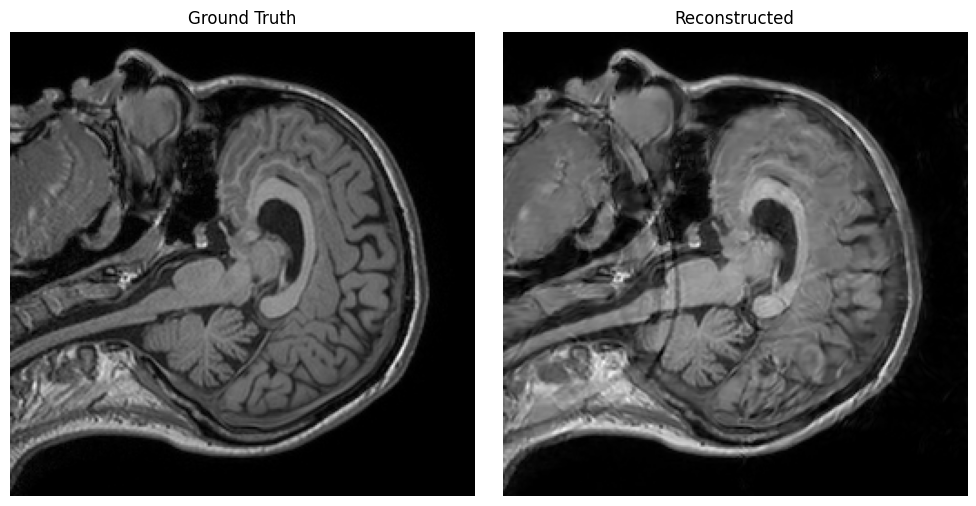

In [19]:
# run demo
import numpy as np
import os
from numpy import fft
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compute_ssim
from skimage.io import imsave
from skimage import img_as_ubyte
import time

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#%% load fully sampled k-space data
ixi_path = '/content/drive/MyDrive/Sem-6/IXI_Dataset/IXI017-Guys-0698-T1.nii.gz'
ixi_img = nib.load(ixi_path)
data = ixi_img.get_fdata()

# Extract a 2D slice (middle slice)
slice_idx = data.shape[2] // 2
gt_mag = data[:, :, slice_idx].astype(np.float32)
# ground-truth as complex with zero phase
gt_complex = gt_mag + 0j

# Dimensions\ n Nrd, Npe = gt_mag.shape
Nchl = 8  # number of coils

# Generate synthetic coil sensitivity maps
sigma = Nrd / 4
csm = np.zeros((Nrd, Npe, Nchl), dtype=np.complex64)
for i in range(Nchl):
    cx = Nrd//2 + (i - Nchl//2) * (Nrd//Nchl)
    cy = Npe//2
    x, y = np.meshgrid(np.arange(Nrd), np.arange(Npe), indexing='ij')
    csm[..., i] = np.exp(-((x-cx)**2 + (y-cy)**2)/(2*sigma**2))
csm /= np.sqrt(np.sum(np.abs(csm)**2, axis=2, keepdims=True))

# Simulate coil images
coil_img = gt_complex[..., None] * csm

# Compute fully sampled k-space
data_cpl = fft.fftshift(fft.fft2(fft.fftshift(coil_img, axes=(0,1)), axes=(0,1)), axes=(0,1))

# Dimensions check (should be Nrd, Npe, Nchl)
Nrd, Npe, Nchl = data_cpl.shape

#%% Parameter settings
Rx = 1
Ry = 4
num_ACSx = Nrd
num_ACSy = 24
w0 = 17
lamda = 1.5

#%% calculate sum-of-squares ground truth image
coil_ifft = fft.fftshift(fft.ifft2(fft.fftshift(data_cpl, axes=(0,1)), axes=(0,1)), axes=(0,1))
gt_sos = np.sqrt(np.sum(np.abs(coil_ifft)**2, axis=2))

#%% perform undersampling
# keep (Nrd, Npe, Nchl) ordering
tstKsp = data_cpl  # no transpose
# build 2D mask and tile across coils
tmp_mask = KspaceUnd(Nrd, Npe, Rx, Ry, num_ACSx, num_ACSy)  # shape (Nrd, Npe)
SamMask = np.tile(tmp_mask[..., None], (1,1,Nchl))
# apply mask
tstDsKsp = tstKsp * SamMask

#%% normalize the undersampled k-space
zf_coil_img = fft.fftshift(fft.ifft2(fft.fftshift(tstDsKsp, axes=(0,1)), axes=(0,1)), axes=(0,1))
norm_factor = np.max(np.sqrt(np.sum(np.abs(zf_coil_img)**2, axis=2)))
tstDsKsp /= norm_factor

#%% Reconstruction
time_start = time.time()
pre_img, pre_csm, pre_img_dc, pre_img_sos, pre_ksp = IMJENSE_Recon(
    tstDsKsp,
    SamMask,
    DEVICE,
    w0=w0,
    TV_weight=lamda,
    PolyOrder=15,
    MaxIter=1500,
    LrImg=1e-4,
    LrCsm=0.1
)
time_end = time.time()
print(f'Reconstruction took {(time_end-time_start)/60:.2f} mins')

#%% Normalize and metrics
normOrg = normalize01(gt_sos)
normRec = normalize01(pre_img_sos)
psnrVal = myPSNR(normOrg, normRec)
ssimVal = compute_ssim(normRec, normOrg, data_range=1, gaussian_weights=True)
print(f'PSNR: {psnrVal:.2f} dB, SSIM: {ssimVal:.4f}')

# save results
os.makedirs('results', exist_ok=True)
imsave('results/gt.png', img_as_ubyte(normOrg))
imsave('results/recon.png', img_as_ubyte(normRec))

# display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normOrg, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(normRec, cmap='gray')
plt.title('Reconstructed')
plt.axis('off')
plt.tight_layout()
plt.show()

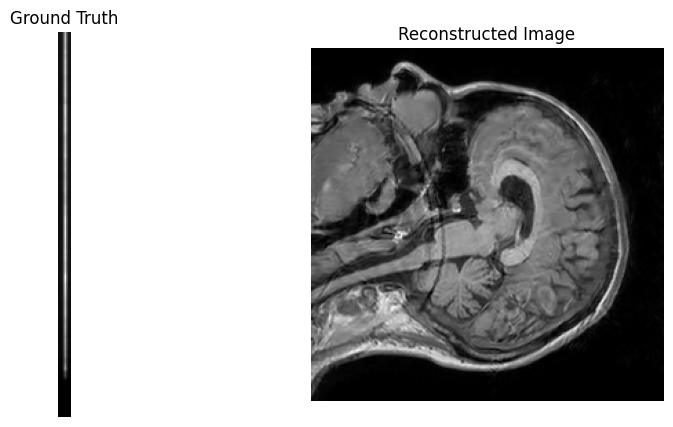

In [15]:
imsave(outpath + '/' + 'gt.png', img_as_ubyte(normOrg))
imsave(outpath + '/' + 'recon.png', img_as_ubyte(normRec))

#%% Display images
plt.figure(figsize=(10, 5))

# Ground truth image
plt.subplot(1, 2, 1)
plt.imshow(normOrg, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(normRec, cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()


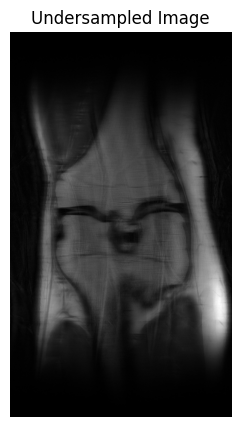

In [ ]:
# run demo
import numpy as np
import h5py as h5
import os
from numpy import fft
import torch
from skimage.metrics import structural_similarity as compute_ssim
from skimage.io import imsave
from scipy.io import loadmat
# import
# import
import time
from skimage import img_as_ubyte  # Import for conversion
import matplotlib.pyplot as plt  # Import for displaying images


os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# DEVICE = torch.device('cuda:{}'.format(str(0) if torch.cuda.is_available() else 'cpu'))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



#%% load fully sampled k-space data
fpath = '/content/drive/MyDrive/sem 6/IMJENSE/data/knee_slice.h5'
f = h5.File(fpath,'r')
data_cpl = f['KspOrg'][:]

outpath = './'+'results'
if not os.path.exists(outpath):
    os.mkdir(outpath)

Nchl,Nrd,Npe = data_cpl.shape
#%% Parameter settings
Rx = 1
Ry = 4
num_ACSx = Nrd
num_ACSy = 24
w0 = 31
lamda = 3.8
fn=lambda x: normalize01(np.abs(x))


tstKsp = data_cpl.transpose(1,2,0)
SamMask = KspaceUnd(Nrd,Npe,Rx,Ry,num_ACSx,num_ACSy)
SamMask = np.tile(np.expand_dims(SamMask,axis=-1),(1,1,Nchl))
tstDsKsp = tstKsp*SamMask

coil_img = fft.fftshift(fft.ifft2(fft.fftshift(tstDsKsp, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))

sos_img = np.sqrt(np.sum(np.abs(zf_coil_img) ** 2, axis=2))

normZf = normalize01(sos_img)

imsave(outpath + '/' + 'undersampled.png', img_as_ubyte(normZf))

plt.figure(figsize=(5, 5))
plt.imshow(normZf, cmap='gray')
plt.title("Undersampled Image")
plt.axis("off")
plt.show()


In [ ]:
import torch

torch.cuda.empty_cache()  # Frees unused GPU memory
torch.cuda.ipc_collect()  # Collects unreferenced memory blocks


In [ ]:
# parameter tuning


import numpy as np
import h5py as h5
import torch
import os
from numpy import fft
# import utils
# import IMJENSE
from skimage.io import imsave
from scipy.io import loadmat
from scipy.io import savemat
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# DEVICE = torch.device('cuda:{}'.format(str(0) if torch.cuda.is_available() else 'cpu'))
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fn=lambda x: normalize01(np.abs(x))

outpath = './parameter_tune_BayesSearch'
if not os.path.exists(outpath):
    os.mkdir(outpath)

#%% load the training data from one subject
import h5py as h5

rpath = '/mnt/288T/frm/IMJENSE_datasets/FastMRI_knee/testing'
fpath = rpath + '/' + 'file1001759.h5'
f = h5.File(fpath,'r')
data_cpl = f['kspace'][:]
Nsli,Nchl,Nrd,Npe = data_cpl.shape

img_all = fft.fftshift(fft.ifft2(fft.fftshift(data_cpl,axes=(-1,-2)),axes=(-1,-2)),axes=(-1,-2))
gt = np.sqrt(np.sum(np.abs(img_all)**2,1))

tmask = loadmat(rpath+'/'+'tmask_file1001759.mat')['tmask'].transpose(2,1,0)

print(tmask)
num_ACSx = Nrd
num_ACSy = 24
Rx = 1
Ry = 4

#%% define the black-box target function
def target_function(w0,Lambda):
    w0 = np.round(w0)

    recon_img = np.zeros((Nsli,Nrd,Npe),dtype = np.complex64)
    recon_csm = np.zeros((Nsli,Nchl,Nrd,Npe),dtype = np.complex64)
    recon_img_dc = np.zeros((Nsli,Nrd,Npe),dtype = np.complex64)
    recon_ksp = np.zeros((Nsli,Nchl,Nrd,Npe),dtype = np.complex64)
    evalmat = np.zeros((Nsli))

    for sli in range(Nsli):
        tstKsp = data_cpl[sli].transpose(1,2,0)

        SamMask = KspaceUnd(Nrd,Npe,Rx,Ry,num_ACSx,num_ACSy)
        SamMask = np.tile(np.expand_dims(SamMask,axis=-1),(1,1,Nchl))
        tstDsKsp = tstKsp*SamMask

        zf_coil_img=fft.fftshift(fft.ifft2(fft.fftshift(tstDsKsp,axes=(0,1)),axes=(0,1)),axes=(0,1))
        NormFactor=np.max(np.sqrt(np.sum(np.abs(zf_coil_img)**2,axis=2)))
        tstDsKsp = tstDsKsp/NormFactor

        pre_img, pre_tstCsm, pre_img_dc, pre_img_sos, pre_ksp  = IMJENSE_Recon(tstDsKsp,SamMask,DEVICE,w0=w0,TV_weight=Lambda,PolyOrder=15,MaxIter=1500,LrImg = 1e-4,LrCsm=0.1)

        recon_img[sli] = pre_img
        recon_csm[sli] = pre_tstCsm.transpose(2,0,1)
        recon_img_dc[sli] = pre_img_dc
        recon_ksp[sli] = pre_ksp.transpose(2,0,1)

        normOrg=fn(gt[sli])*tmask[sli]
        normRec=fn(pre_img_dc)*tmask[sli]

        psnrRec=myPSNR(normOrg,normRec)
        evalmat[sli] = psnrRec

    imsave(outpath + '/' + 'gt.png',fn(gt[4]*tmask[4]))
    imsave(outpath + '/' + 'recon_w0'+str(w0)+'_TV'+str(Lambda)+'.png',fn(recon_img_dc[4]*tmask[4]))
    savemat(outpath+'/'+'recon_w0'+str(w0)+'_TV'+str(Lambda)+'.mat',
        {'recon_img':recon_img,
         'recon_csm':recon_csm,
         'recon_img_dc':recon_img_dc,
         'recon_ksp':recon_ksp,
         'evalmat':evalmat})
    return np.mean(evalmat)

#%% Bounded region of parameter space
pbounds = {'w0':(10,50),'Lambda':(0,100)}
logger = JSONLogger(path=outpath+'/'+'logs')
optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    allow_duplicate_points=True
)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)
optimizer.maximize(init_points=4, n_iter=20)


print("Optimal value of w0:", optimizer.max['params']['w0'])
print("Optimal value of Lambda:", optimizer.max['params']['Lambda'])
print("Optimal function value:", optimizer.max['target'])

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/288T/frm/IMJENSE_datasets/FastMRI_knee/testing/file1001759.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)